In [4]:
# !pip install folium
# !pip install geopandas
# !pip install rasterio

In [5]:
# Import necessary libraries
import folium
import numpy as np
# Import necessary libraries
# import folium
import rasterio
# from rasterio.plot import show
import rasterio.plot
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
from PIL import Image
import pandas as pd

In [3]:
# Define locations
tibetan_plateau_location = (34.25, 88.75)
mount_everest_location = (27.9881, 86.9250)
k2_location = (35.8825, 76.5133)

# Define map
interactive_map = folium.Map(location=tibetan_plateau_location, zoom_start=6)

tile = folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = False,
        control = True
       ).add_to(interactive_map)

# Add markers
folium.Marker(location=mount_everest_location, popup="Mount Everest").add_to(interactive_map)
folium.Marker(location=k2_location, popup="K2").add_to(interactive_map)

# Add GeoJSON layer
# folium.GeoJson(
#     data=open("tibetan_plateau.geojson", "r").read(),
#     name="geojson"
# ).add_to(interactive_map)

# Show the map
interactive_map

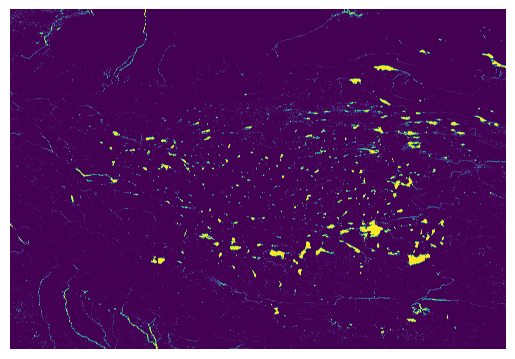

In [18]:
# Load the GeoTIFF file
# with rasterio.open('path_to_your_tiff_file.tif') as src:
with rasterio.open('data/water_maxoccurrence-0000000000-0000000000.tif') as src:
    # Use rasterio to get the bounds of the image
    bounds = src.bounds
    # Read the file into a numpy array
    img = src.read()

# Create a figure and axes for Matplotlib
fig, ax = plt.subplots()
# Plot the image on the axes
# rasterio
rasterio.plot.show(img, ax=ax)

ax.axis('off')
# Save the figure as a PNG
fig.canvas.draw()
fig.savefig('temp.png', dpi=300, bbox_inches='tight', pad_inches=0)

In [19]:
bounds

BoundingBox(left=76.09395209802594, bottom=27.539382170666943, right=93.75554923604302, top=39.631334715614585)

In [20]:
img[0].shape

(44869, 65536)

In [21]:
# img.max()

In [22]:
# plt.imshow(img[0])

In [23]:
# IMG = Image.fromarray((img[0] * 255).astype(np.uint8))
# IMG.save("temp.png")

In [29]:
!pip install Pillow

In [30]:
!pip install scipy

In [33]:
from imageio import imread


In [34]:
IMG = imread('data/water_maxoccurrence-0000000000-0000000000.tif')

/var/folders/20/67zvnfrd4qn0q8029j2qbpqw0000gn/T/ipykernel_23011/3484169495.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  IMG = imread('data/water_maxoccurrence-0000000000-0000000000.tif')


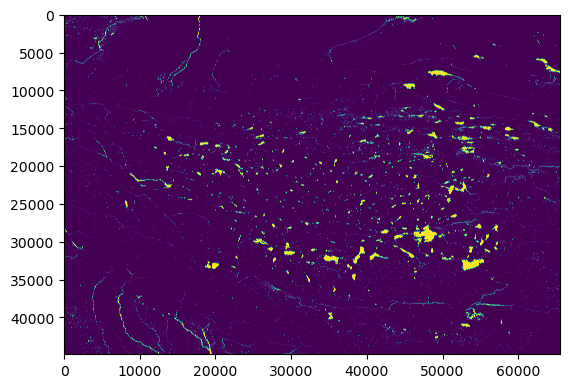

In [38]:
plt.imshow(IMG)

In [41]:
# Define the map
interactive_map = folium.Map(location=[bounds[1], bounds[0]], zoom_start=12)

tile = folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = False,
        control = True
       ).add_to(interactive_map)


# Add the PNG as an overlay
folium.raster_layers.ImageOverlay(
    # image='temp.png',
    image=[IMG],
    bounds=[[bounds[1], bounds[0]], [bounds[3], bounds[2]]],
    opacity=0.7
).add_to(interactive_map)

# Show the map
interactive_map


TypeError: Object of type Array is not JSON serializable

# Differencing rasters

Next we want to look at where water growth is occuring. So we take the stack of annual water occurence and difference them from year to year. Then we will sum them for each catchment.



In [ ]:
# difference stack of rasters

In [ ]:
# import catchement shapes

In [ ]:
# select data from catchement shapes

In [ ]:
# sum data for each catchment

In [ ]:
# make map of region with catchments colored by total change

# Next we need to download covariate data, we will start with the ERA5-land precipitation data

Since it is likely that lakes are growing because it is raining, at least in part, we download ERA5-land data for 1984 until 2021. Then we plot it. This will be used as a covariate in the model.

If you do not have API access to CDS then you should go here first:

https://cds.climate.copernicus.eu/api-how-to

In [1]:
!pip install cdsapi

  Preparing metadata (setup.py) ... done
  Created wheel for cdsapi: filename=cdsapi-0.6.1-py2.py3-none-any.whl size=12010 sha256=95eb3b1a30321ee55b78787ae99a78b6e9174413447c5540d87bdd892ab14e49
  Stored in directory: /Users/johnaiken/Library/Caches/pip/wheels/44/41/9f/0496669868806af6199469106f670aed4e4d454558f6081d81
Successfully built cdsapi


In [7]:
# this may take some time to run

import cdsapi

c = cdsapi.Client()

years = np.arange(1984, 2022, 1)
days = [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
            '13', '14', '15',
            '16', '17', '18',
            '19', '20', '21',
            '22', '23', '24',
            '25', '26', '27',
            '28', '29', '30',
            '31',
        ]
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
times = '23:00'
area = [45, 68, 24, 107]

for year in years:
    year = str(year)
    c.retrieve('reanalysis-era5-land', {'year':year, 'month':months, 'time':times, 'day':days, 'area':area
                                       ,'variable':'total_precipitation', 'format':'netcdf.zip'}
              ,'precip-'+year+'netcdf.zip')
    
# c.retrieve(
#     'reanalysis-era5-land',
#     {
#         # 'year': ['1985', '1986'],
#         'year': [str(year) for year in np.arange(1984, 2022, 1)],
#         # 'month': '01',
#         'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'],
#         'time': '23:00',
#         'day': [
#             '01', '02', '03',
#             '04', '05', '06',
#             '07', '08', '09',
#             '10', '11', '12',
#             '13', '14', '15',
#             '16', '17', '18',
#             '19', '20', '21',
#             '22', '23', '24',
#             '25', '26', '27',
#             '28', '29', '30',
#             '31',
#         ],
#         'area': [
#             45, 68, 24,
#             107,
#         ],
#         'variable': 'total_precipitation',
#         'format': 'netcdf.zip',
#     },
#     'download.netcdf.zip')


2023-05-16 14:39:21,230 INFO Welcome to the CDS
2023-05-16 14:39:21,232 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-land
2023-05-16 14:39:21,287 INFO Request is queued
2023-05-16 14:39:22,364 INFO Request is running
2023-05-16 14:41:15,393 INFO Request is completed
2023-05-16 14:41:15,402 INFO Downloading https://download-0010-clone.copernicus-climate.eu/cache-compute-0010/cache/data0/adaptor.mars.internal-1684240835.951421-26331-11-494e5dbe-0640-48b9-acd4-b3ace3f1e959.zip to precip-1984netcdf.zip (25.1M)
2023-05-16 14:41:25,000 INFO Download rate 2.6M/s                                                                                       
2023-05-16 14:41:25,098 INFO Welcome to the CDS
2023-05-16 14:41:25,100 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-land
2023-05-16 14:41:25,174 INFO Request is queued
2023-05-16 14:41:27,784 INFO Request is running
2023-05-16 14:43:19,052 INFO Request is co

In [ ]:
# download ERA5-land precipitation data

In [ ]:
# make map of ERA5-land precipitation data

# Now we combine everything into one data set for 4DM

Since the model is implemented in R we first will create the dataset for that model, then export it. Then, in a separate R-markdown file, we will do the modeling.

This process will be used as the basis to create all of the covariates used in the model.

We will also include data from the hydrobasins dataset, such as whether a catchment is connected or not

In [ ]:
# combine data into pandas dataframe

df = pd.DataFrame({
        'lake_growth (m^2)':lake_growth
        ,'annual_precipitation':ann_precip
        ,'connected_basin':conn_basin
    }
    ,index=catchment_id
)